# Crop Price Prediction

## Importing the Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer

## Data Loading & Cleaning Functions

In [57]:
df = pd.read_excel("merged_output.xlsx")

In [77]:
df.head()

,Sl no.,District Name,Market Name,Commodity,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Price Date,SourceFile,State Name,Group,Min Price (Rs/Quintal),Max Price (Rs/Quintal),Modal Price (Rs/Quintal)
0,1,Malda,Gajol,Groundnut,5500.0,5800.0,5700.0,31 Dec 2020,/Users/adithyan/Desktop/2020/Groundnut 2020w.xls,NaN,NaN,NaN,NaN,NaN
1,2,Malda,Gajol,Groundnut,5500.0,6000.0,5800.0,06 Aug 2020,/Users/adithyan/Desktop/2020/Groundnut 2020w.xls,NaN,NaN,NaN,NaN,NaN
2,3,Malda,Gajol,Groundnut,5500.0,6000.0,5800.0,09 Aug 2020,/Users/adithyan/Desktop/2020/Groundnut 2020w.xls,NaN,NaN,NaN,NaN,NaN
3,4,Malda,Gajol,Groundnut,5800.0,6100.0,5900.0,12 Nov 2020,/Users/adithyan/Desktop/2020/Groundnut 2020w.xls,NaN,NaN,NaN,NaN,NaN
4,5,Malda,Gajol,Groundnut,5800.0,6200.0,6000.0,03 Sep 2020,/Users/adithyan/Desktop/2020/Groundnut 2020w.xls,NaN,NaN,NaN,NaN,NaN


In [78]:
df = df.replace([" ", "", "NA", "N/A", "na", "null", "Null"], np.nan).infer_objects(copy=False)

In [79]:
df.drop(columns="Group",inplace=True)

In [80]:
df = df.dropna(axis=1, thresh=100)

In [81]:
df.index = range(1, len(df) + 1)

In [82]:
df["Price Date"] = pd.to_datetime(df["Price Date"], errors="coerce")

In [83]:
df["Year"] = df["Price Date"].dt.year

In [84]:
df["Price Date"] = pd.to_datetime(df["Price Date"], errors="coerce")
df["Month"] = df["Price Date"].dt.month

def get_season(month):
    if month in [6, 7, 8, 9, 10]: 
        return "Kharif"
    elif month in [11, 12, 1, 2, 3]: 
        return "Rabi"
    elif month in [4, 5]:           
        return "Zaid"
    else:
        return "Unknown"

df["Season"] = df["Month"].apply(get_season)

In [85]:
df.head()

,Sl no.,District Name,Market Name,Commodity,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Price Date,SourceFile,Year,Month,Season
1,1,Malda,Gajol,Groundnut,5500.0,5800.0,5700.0,2020-12-31,/Users/adithyan/Desktop/2020/Groundnut 2020w.xls,2020,12,Rabi
2,2,Malda,Gajol,Groundnut,5500.0,6000.0,5800.0,2020-08-06,/Users/adithyan/Desktop/2020/Groundnut 2020w.xls,2020,8,Kharif
3,3,Malda,Gajol,Groundnut,5500.0,6000.0,5800.0,2020-08-09,/Users/adithyan/Desktop/2020/Groundnut 2020w.xls,2020,8,Kharif
4,4,Malda,Gajol,Groundnut,5800.0,6100.0,5900.0,2020-11-12,/Users/adithyan/Desktop/2020/Groundnut 2020w.xls,2020,11,Rabi
5,5,Malda,Gajol,Groundnut,5800.0,6200.0,6000.0,2020-09-03,/Users/adithyan/Desktop/2020/Groundnut 2020w.xls,2020,9,Kharif


In [86]:
df["Season"].value_counts()

Season
Rabi      415540
Kharif    382603
Zaid      156245
Name: count, dtype: int64

In [87]:
df["Commodity"].value_counts()

Commodity
Potato                 408802
Wheat                  277341
Paddy(Dhan)(Common)    108068
Maize                  101208
Groundnut               33317
Cotton                  25515
Coconut                   137
Name: count, dtype: int64

In [88]:
df["District Name"].value_counts()

District Name
Hardoi              18180
Bulandshahar        16620
Badaun              16590
Ahmednagar          16082
Nashik              16062
                    ...  
Chamrajnagar          399
Kalburgi              381
Madikeri(Kodagu)       94
Kolhapur               88
Ratnagiri               4
Name: count, Length: 178, dtype: int64

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954388 entries, 1 to 954388
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Sl no.                     954388 non-null  int64         
 1   District Name              954388 non-null  object        
 2   Market Name                954388 non-null  object        
 3   Commodity                  954388 non-null  object        
 4   Min Price (Rs./Quintal)    954388 non-null  float64       
 5   Max Price (Rs./Quintal)    954388 non-null  float64       
 6   Modal Price (Rs./Quintal)  954388 non-null  float64       
 7   Price Date                 954388 non-null  datetime64[ns]
 8   SourceFile                 954388 non-null  object        
 9   Year                       954388 non-null  int32         
 10  Month                      954388 non-null  int32         
 11  Season                     954388 non-null  object  

In [90]:
df["District Name"].unique()

array(['Malda', 'Amarawati', 'Ahmednagar', 'Jalgaon', 'Jalana', 'Pune',
       'Sholapur', 'Beed', 'Nanded', 'Akola', 'Nashik',
       'Chattrapati Sambhajinagar', 'Buldhana', 'Latur', 'Dhule',
       'Nandurbar', 'Gadchiroli', 'Dharashiv(Usmanabad)', 'Raigad',
       'Nagpur', 'Mumbai', 'Satara', 'Sangli', 'Prayagraj', 'Maharajganj',
       'Banda', 'Mainpuri', 'Mahoba', 'Jhansi', 'Etah', 'Ghaziabad',
       'Lalitpur', 'Hardoi', 'Meerut', 'Hamirpur', 'Saharanpur', 'Shamli',
       'Amethi', 'Chandrapur', 'Thane', 'Ratnagiri', 'Hassan',
       'Chikmagalur', 'Bangalore', 'Kolar', 'Belgaum', 'Davangere',
       'Bellary', 'Dharwad', 'Chamrajnagar', 'Kalburgi', 'Mandya',
       'Mangalore(Dakshin Kannad)', 'Mysore', 'Shimoga', 'Udupi',
       'Tumkur', 'Kolhapur', 'Auraiya', 'Agra', 'Aligarh', 'Bulandshahar',
       'Badaun', 'Bahraich', 'Balrampur', 'Unnao', 'Barabanki',
       'Bareilly', 'Etawah', 'Sambhal', 'Bijnor', 'Kannuj', 'Kanpur',
       'Gautam Budh Nagar', 'Deoria', 'Ayodhya

In [91]:
district_to_state = {
    "Ahmednagar": "Maharashtra",
    "Sholapur": "Maharashtra",  # Solapur
    "Amarawati": "Maharashtra",  # Amravati
    "Chandrapur": "Maharashtra",
    "Chattrapati Sambhajinagar": "Maharashtra",  # Aurangabad (renamed)
    "Dharashiv(Usmanabad)": "Maharashtra",  # Osmanabad
    "Sangli": "Maharashtra",
    "Jalgaon": "Maharashtra",
    "Pune": "Maharashtra",
    "Nagpur": "Maharashtra",
    "Satara": "Maharashtra",
    "Thane": "Maharashtra",
    "Nashik": "Maharashtra",
    "Mumbai": "Maharashtra",  
    "Ratnagiri": "Maharashtra",
    "Nandurbar": "Maharashtra",
    "Latur": "Maharashtra",
    "Akola": "Maharashtra",
    "Jalana": "Maharashtra",  # Jalna
    "Beed": "Maharashtra",
    "Nanded": "Maharashtra",
    "Buldhana": "Maharashtra",
    "Dhule": "Maharashtra",
    "Raigad": "Maharashtra",
    "Gadchiroli": "Maharashtra",
    "Yavatmal": "Maharashtra",
    "Vashim": "Maharashtra",  # Washim
    "Hingoli": "Maharashtra",
    "Wardha": "Maharashtra",
    "Parbhani": "Maharashtra",
    "Gondiya": "Maharashtra",  # Gondia
    "Bhandara": "Maharashtra",
    "Prayagraj": "Uttar Pradesh",  # Allahabad
    "Bareilly": "Uttar Pradesh",
    "Mainpuri": "Uttar Pradesh",
    "Mahoba": "Uttar Pradesh",
    "Jhansi": "Uttar Pradesh",
    "Etah": "Uttar Pradesh",
    "Ayodhya": "Uttar Pradesh",  # Faizabad
    "Farukhabad": "Uttar Pradesh",  # Farrukhabad
    "Saharanpur": "Uttar Pradesh",
    "Lalitpur": "Uttar Pradesh",
    "Hardoi": "Uttar Pradesh",
    "Meerut": "Uttar Pradesh",
    "Rampur": "Uttar Pradesh",
    "Agra": "Uttar Pradesh",
    "Shamli": "Uttar Pradesh",
    "Amethi": "Uttar Pradesh",
    "Hathras": "Uttar Pradesh",
    "Aligarh": "Uttar Pradesh",
    "Mathura": "Uttar Pradesh",
    "Auraiya": "Uttar Pradesh",
    "Ambedkarnagar": "Uttar Pradesh",  # Ambedkar Nagar
    "Maharajganj": "Uttar Pradesh",
    "Banda": "Uttar Pradesh",
    "Azamgarh": "Uttar Pradesh",
    "Amroha": "Uttar Pradesh",
    "Badaun": "Uttar Pradesh",
    "Raebarelli": "Uttar Pradesh",  # Rae Bareli
    "Shahjahanpur": "Uttar Pradesh",
    "Bahraich": "Uttar Pradesh",
    "Ballia": "Uttar Pradesh",
    "Balrampur": "Uttar Pradesh",
    "Unnao": "Uttar Pradesh",
    "Barabanki": "Uttar Pradesh",
    "Deoria": "Uttar Pradesh",
    "Basti": "Uttar Pradesh",
    "Etawah": "Uttar Pradesh",
    "Kaushambi": "Uttar Pradesh",
    "Fatehpur": "Uttar Pradesh",
    "Sambhal": "Uttar Pradesh",
    "Chandauli": "Uttar Pradesh",
    "Kannuj": "Uttar Pradesh",  # Kannauj
    "Gorakhpur": "Uttar Pradesh",
    "Kanpur": "Uttar Pradesh",  # Kanpur Nagar
    "Lucknow": "Uttar Pradesh",
    "Hamirpur": "Uttar Pradesh",
    "Gautam Budh Nagar": "Uttar Pradesh",
    "Mau(Maunathbhanjan)": "Uttar Pradesh",  # Mau
    "Pillibhit": "Uttar Pradesh",  # Pilibhit
    "Bijnor": "Uttar Pradesh",
    "Lakhimpur": "Uttar Pradesh",  # Lakhimpur Kheri
    "Gonda": "Uttar Pradesh",
    "Bhadohi(Sant Ravi Nagar)": "Uttar Pradesh",  # Bhadohi
    "Sitapur": "Uttar Pradesh",
    "Ghazipur": "Uttar Pradesh",
    "Jaunpur": "Uttar Pradesh",
    "Kanpur Dehat": "Uttar Pradesh",
    "Chitrakut": "Uttar Pradesh",  # Chitrakoot
    "Sant Kabir Nagar": "Uttar Pradesh",
    "Khiri (Lakhimpur)": "Uttar Pradesh",
    "Mirzapur": "Uttar Pradesh",
    "Siddharth Nagar": "Uttar Pradesh",
    "Shravasti": "Uttar Pradesh",
    "Pratapgarh": "Uttar Pradesh",
    "Firozabad": "Uttar Pradesh",
    "Bulandshahar": "Uttar Pradesh",
    "Kushinagar": "Uttar Pradesh",
    "Jalaun (Orai)": "Uttar Pradesh",
    "Baghpat": "Uttar Pradesh",
    "Ghaziabad": "Uttar Pradesh",
    "Kasganj": "Uttar Pradesh",
    "Muzaffarnagar": "Uttar Pradesh",
    "Sonbhadra": "Uttar Pradesh",
    "Varanasi": "Uttar Pradesh",
    "Fazilka": "Punjab",
    "Amritsar": "Punjab",
    "Fatehgarh": "Punjab",  # Fatehgarh Sahib
    "Moga": "Punjab",
    "Mansa": "Punjab",
    "Muktsar": "Punjab",
    "Patiala": "Punjab",
    "Jalandhar": "Punjab",
    "Tarntaran": "Punjab",  # Tarn Taran
    "Hoshiarpur": "Punjab",
    "Barnala": "Punjab",
    "Gurdaspur": "Punjab",
    "Faridkot": "Punjab",
    "Ludhiana": "Punjab",
    "Bhatinda": "Punjab",  # Bathinda
    "Sangrur": "Punjab",
    "kapurthala": "Punjab",
    "Ferozpur": "Punjab",  # Firozpur
    "Nawanshahr": "Punjab",  # SBS Nagar
    "Ropar (Rupnagar)": "Punjab",
    "Pathankot": "Punjab",
    "Mohali": "Punjab",
    "Hassan": "Karnataka",
    "Chikmagalur": "Karnataka",
    "Bangalore": "Karnataka",  # Bengaluru Urban
    "Kolar": "Karnataka",
    "Belgaum": "Karnataka",  # Belagavi
    "Bellary": "Karnataka",  # Ballari
    "Chamrajnagar": "Karnataka",  # Chamarajanagar
    "Davangere": "Karnataka",
    "Dharwad": "Karnataka",
    "Gadag": "Karnataka",
    "Haveri": "Karnataka",
    "Mysore": "Karnataka",  # Mysuru
    "Mangalore(Dakshin Kannad)": "Karnataka",  # Dakshina Kannada
    "Shimoga": "Karnataka",  # Shivamogga
    "Tumkur": "Karnataka",  # Tumakuru
    "Udupi": "Karnataka",
    "Bidar": "Karnataka",
    "Chitradurga": "Karnataka",
    "Bagalkot": "Karnataka",
    "Bijapur": "Karnataka",  # Vijayapura
    "Koppal": "Karnataka",
    "Karwar(Uttar Kannad)": "Karnataka",  # Uttara Kannada
    "Raichur": "Karnataka",
    "Yadgiri": "Karnataka",  # Yadgir
    "Madikeri(Kodagu)": "Karnataka",
    "Mandya": "Karnataka",
    "Kalburgi": "Karnataka",  # Gulbarga
    "Malda": "West Bengal",
    "Paschim Bardhaman": "West Bengal",
    "Bankura": "West Bengal",
    "Birbhum": "West Bengal",
    "Murshidabad": "West Bengal",
    "Coochbehar": "West Bengal",
    "Jalpaiguri": "West Bengal",
    "Purba Bardhaman": "West Bengal",
    "Medinipur(W)": "West Bengal",  # Paschim Medinipur
    "Hooghly": "West Bengal",
    "Nadia": "West Bengal",
    "Darjeeling": "West Bengal",
    "Alipurduar": "West Bengal",
    "Puruliya": "West Bengal",
    "Dakshin Dinajpur": "West Bengal",
    "Kolkata": "West Bengal",
    "North 24 Parganas": "West Bengal",
    "Sounth 24 Parganas": "West Bengal",  # South 24 Parganas
    "Uttar Dinajpur": "West Bengal",
    "Jhargram": "West Bengal",
    "Kalimpong": "West Bengal",
    "Medinipur(E)": "West Bengal",  # Purba Medinipur
    "Howrah": "West Bengal",
    "Kolhapur": "Maharashtra",
}


In [92]:
df["State"] = df["District Name"].map(district_to_state)

missing = df[df["State"].isna()]["District Name"].unique()
print("Unmapped districts:", missing)


Unmapped districts: []


In [93]:
df["Price Volatility"] = (df["Max Price (Rs./Quintal)"] - df["Min Price (Rs./Quintal)"]) / df["Modal Price (Rs./Quintal)"]

In [94]:
df["Price Spread"] = df["Max Price (Rs./Quintal)"] - df["Min Price (Rs./Quintal)"]

In [95]:
df.head()

,Sl no.,District Name,Market Name,Commodity,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Price Date,SourceFile,Year,Month,Season,State,Price Volatility,Price Spread
1,1,Malda,Gajol,Groundnut,5500.0,5800.0,5700.0,2020-12-31,/Users/adithyan/Desktop/2020/Groundnut 2020w.xls,2020,12,Rabi,West Bengal,0.052632,300.0
2,2,Malda,Gajol,Groundnut,5500.0,6000.0,5800.0,2020-08-06,/Users/adithyan/Desktop/2020/Groundnut 2020w.xls,2020,8,Kharif,West Bengal,0.086207,500.0
3,3,Malda,Gajol,Groundnut,5500.0,6000.0,5800.0,2020-08-09,/Users/adithyan/Desktop/2020/Groundnut 2020w.xls,2020,8,Kharif,West Bengal,0.086207,500.0
4,4,Malda,Gajol,Groundnut,5800.0,6100.0,5900.0,2020-11-12,/Users/adithyan/Desktop/2020/Groundnut 2020w.xls,2020,11,Rabi,West Bengal,0.050847,300.0
5,5,Malda,Gajol,Groundnut,5800.0,6200.0,6000.0,2020-09-03,/Users/adithyan/Desktop/2020/Groundnut 2020w.xls,2020,9,Kharif,West Bengal,0.066667,400.0


In [96]:
df["State"].value_counts()

State
Uttar Pradesh    504433
Maharashtra      178572
West Bengal      117823
Punjab            87756
Karnataka         65804
Name: count, dtype: int64

In [97]:
df.isnull().sum()

Sl no.                       0
District Name                0
Market Name                  0
Commodity                    0
Min Price (Rs./Quintal)      0
Max Price (Rs./Quintal)      0
Modal Price (Rs./Quintal)    0
Price Date                   0
SourceFile                   0
Year                         0
Month                        0
Season                       0
State                        0
Price Volatility             8
Price Spread                 0
dtype: int64

In [98]:
df.dropna(inplace=True)

In [99]:
df.isnull().sum()

Sl no.                       0
District Name                0
Market Name                  0
Commodity                    0
Min Price (Rs./Quintal)      0
Max Price (Rs./Quintal)      0
Modal Price (Rs./Quintal)    0
Price Date                   0
SourceFile                   0
Year                         0
Month                        0
Season                       0
State                        0
Price Volatility             0
Price Spread                 0
dtype: int64

In [100]:
df.duplicated().sum()

0

In [101]:
duplicates = df.columns[df.columns.duplicated()]
print("Duplicate columns:", duplicates)

Duplicate columns: Index([], dtype='object')


In [102]:
df.drop(columns=["SourceFile"], inplace=True)


In [103]:
print(df.shape)
print(df.info())      
print(df.head()) 

(954380, 14)
<class 'pandas.core.frame.DataFrame'>
Index: 954380 entries, 1 to 954388
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Sl no.                     954380 non-null  int64         
 1   District Name              954380 non-null  object        
 2   Market Name                954380 non-null  object        
 3   Commodity                  954380 non-null  object        
 4   Min Price (Rs./Quintal)    954380 non-null  float64       
 5   Max Price (Rs./Quintal)    954380 non-null  float64       
 6   Modal Price (Rs./Quintal)  954380 non-null  float64       
 7   Price Date                 954380 non-null  datetime64[ns]
 8   Year                       954380 non-null  int32         
 9   Month                      954380 non-null  int32         
 10  Season                     954380 non-null  object        
 11  State                      954380 non-null  

# 📊 Exploratory Data Analysis (EDA) for Agricultural Price Dataset

In [104]:
# Ensure plots look good
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [105]:
df[["Min Price (Rs./Quintal)", "Max Price (Rs./Quintal)", "Modal Price (Rs./Quintal)"]].describe()

,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal)
count,954380.000000,954380.000000,954380.000000
mean,1805.552693,2045.327907,1944.048888
std,1154.580560,1410.118886,1272.728575
min,0.000000,0.000000,0.000000
25%,1100.000000,1300.000000,1200.000000
50%,1710.000000,1873.000000,1815.000000
75%,2050.000000,2203.000000,2150.000000
max,50509.000000,180013.000000,63869.000000


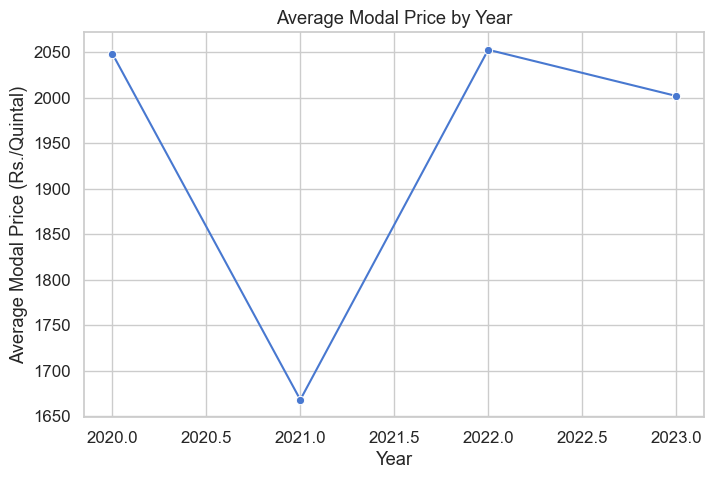

In [106]:
yearly_trend = df.groupby("Year")["Modal Price (Rs./Quintal)"].mean()

plt.figure(figsize=(8,5))
sns.lineplot(x=yearly_trend.index, y=yearly_trend.values, marker="o")
plt.title("Average Modal Price by Year")
plt.xlabel("Year")
plt.ylabel("Average Modal Price (Rs./Quintal)")
plt.show()

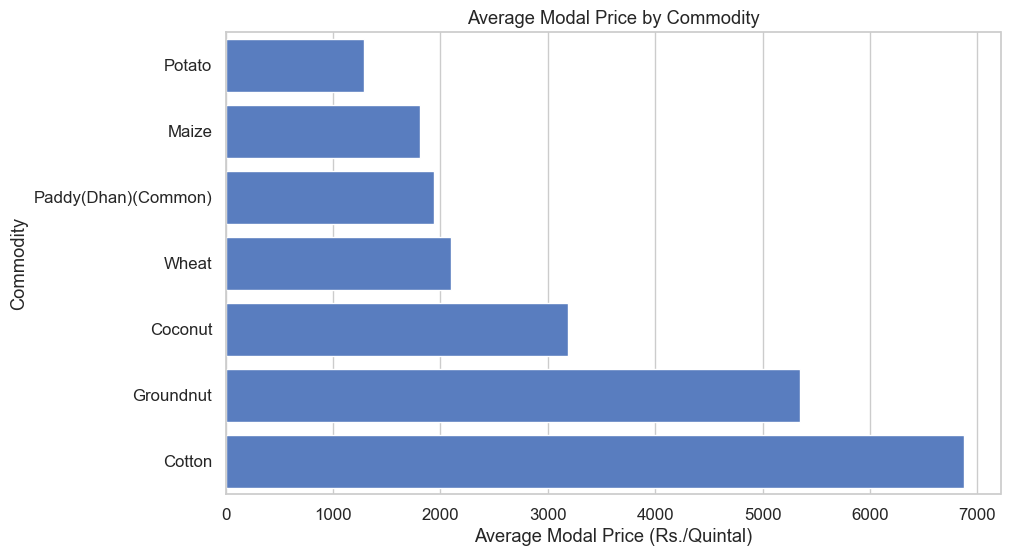

In [107]:
commodity_price = df.groupby("Commodity")["Modal Price (Rs./Quintal)"].mean().sort_values()

plt.figure(figsize=(10,6))
sns.barplot(x=commodity_price.values, y=commodity_price.index)
plt.title("Average Modal Price by Commodity")
plt.xlabel("Average Modal Price (Rs./Quintal)")
plt.ylabel("Commodity")
plt.show()

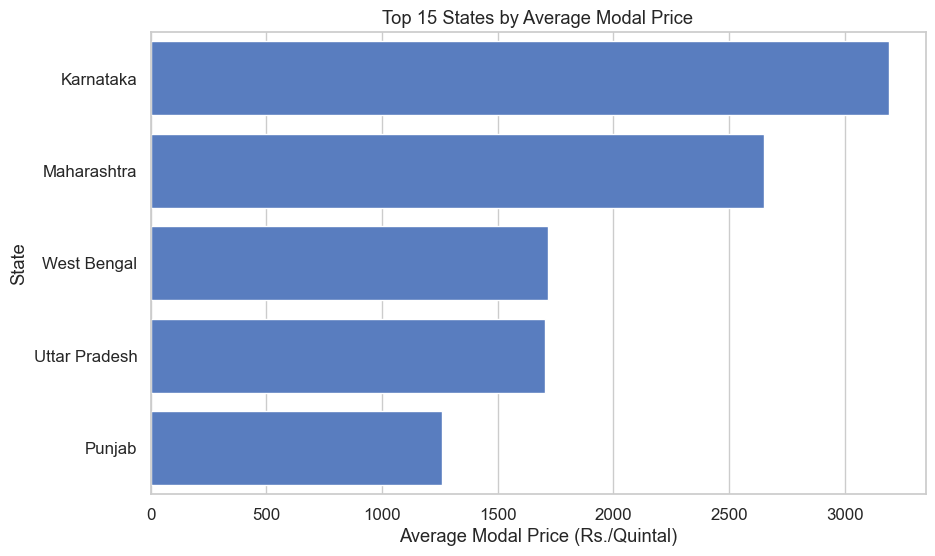

In [108]:
state_price = df.groupby("State")["Modal Price (Rs./Quintal)"].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=state_price.values, y=state_price.index)
plt.title("Top 15 States by Average Modal Price")
plt.xlabel("Average Modal Price (Rs./Quintal)")
plt.ylabel("State")
plt.show()


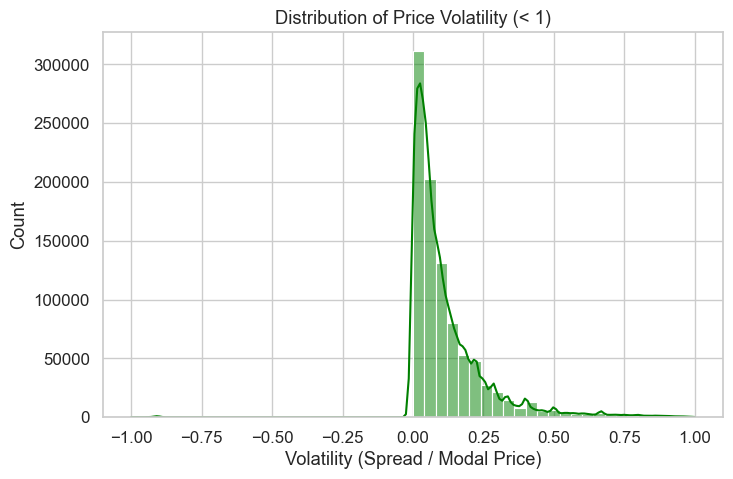

In [109]:
plt.figure(figsize=(8,5))
sns.histplot(df[df["Price Volatility"] < 1]["Price Volatility"], bins=50, kde=True, color="green")
plt.title("Distribution of Price Volatility (< 1)")
plt.xlabel("Volatility (Spread / Modal Price)")
plt.show()

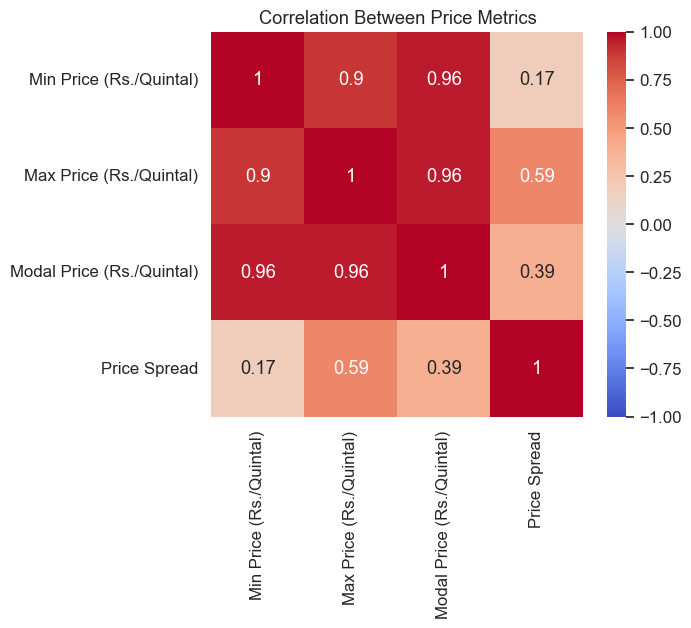

In [110]:
plt.figure(figsize=(6,5))
sns.heatmap(df[["Min Price (Rs./Quintal)",
                "Max Price (Rs./Quintal)",
                "Modal Price (Rs./Quintal)",
                "Price Spread"]].corr(), 
            annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Between Price Metrics")
plt.show()

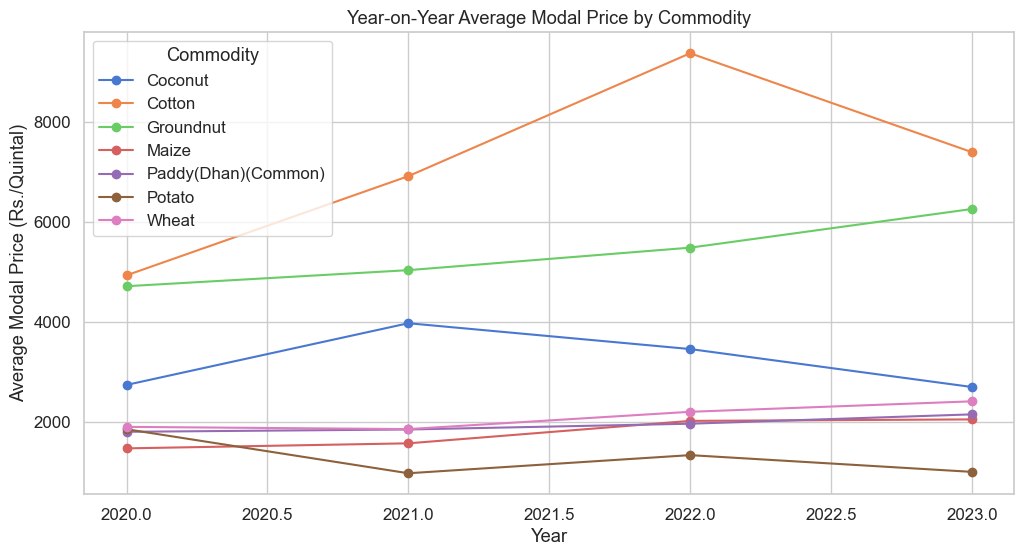

In [111]:
yoy_growth = df.groupby(["Year","Commodity"])["Modal Price (Rs./Quintal)"].mean().unstack()

yoy_growth.plot(figsize=(12,6), marker="o")
plt.title("Year-on-Year Average Modal Price by Commodity")
plt.xlabel("Year")
plt.ylabel("Average Modal Price (Rs./Quintal)")
plt.legend(title="Commodity")
plt.show()

Total outliers found: 36268


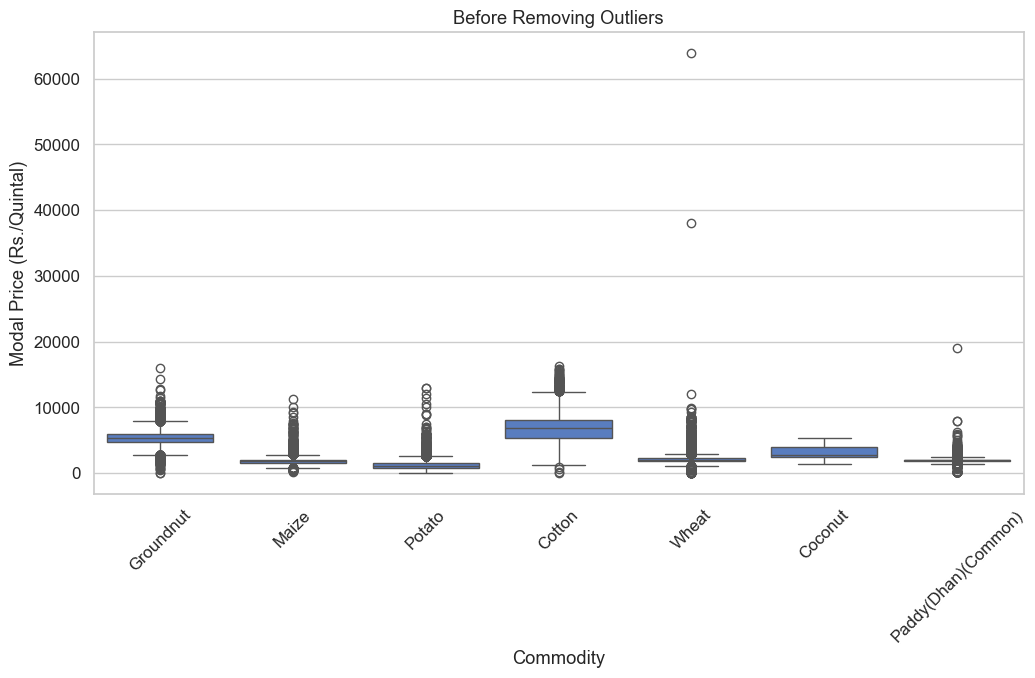

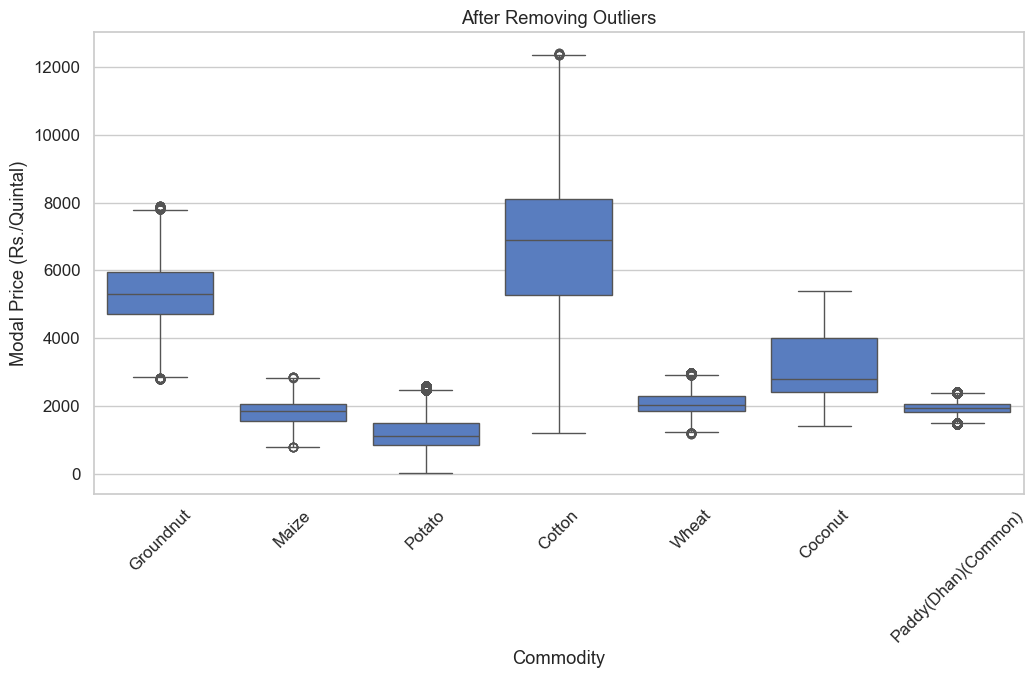

In [112]:
def detect_outliers(df, column, group_col):
    outliers = pd.DataFrame()
    for commodity, subset in df.groupby(group_col):
        Q1 = subset[column].quantile(0.25)
        Q3 = subset[column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        # Flag outliers
        subset_outliers = subset[(subset[column] < lower) | (subset[column] > upper)]
        outliers = pd.concat([outliers, subset_outliers])
    
    return outliers


outlier_df = detect_outliers(df, "Modal Price (Rs./Quintal)", "Commodity")
print("Total outliers found:", len(outlier_df))


outlier_ratio = (
    outlier_df.groupby("Commodity").size() / df.groupby("Commodity").size()
).sort_values(ascending=False)


plt.figure(figsize=(12,6))
sns.boxplot(x="Commodity", y="Modal Price (Rs./Quintal)", data=df)
plt.xticks(rotation=45)
plt.title("Before Removing Outliers")
plt.show()


df_no_outliers = df.drop(outlier_df.index)

plt.figure(figsize=(12,6))
sns.boxplot(x="Commodity", y="Modal Price (Rs./Quintal)", data=df_no_outliers)
plt.xticks(rotation=45)
plt.title("After Removing Outliers")
plt.show()

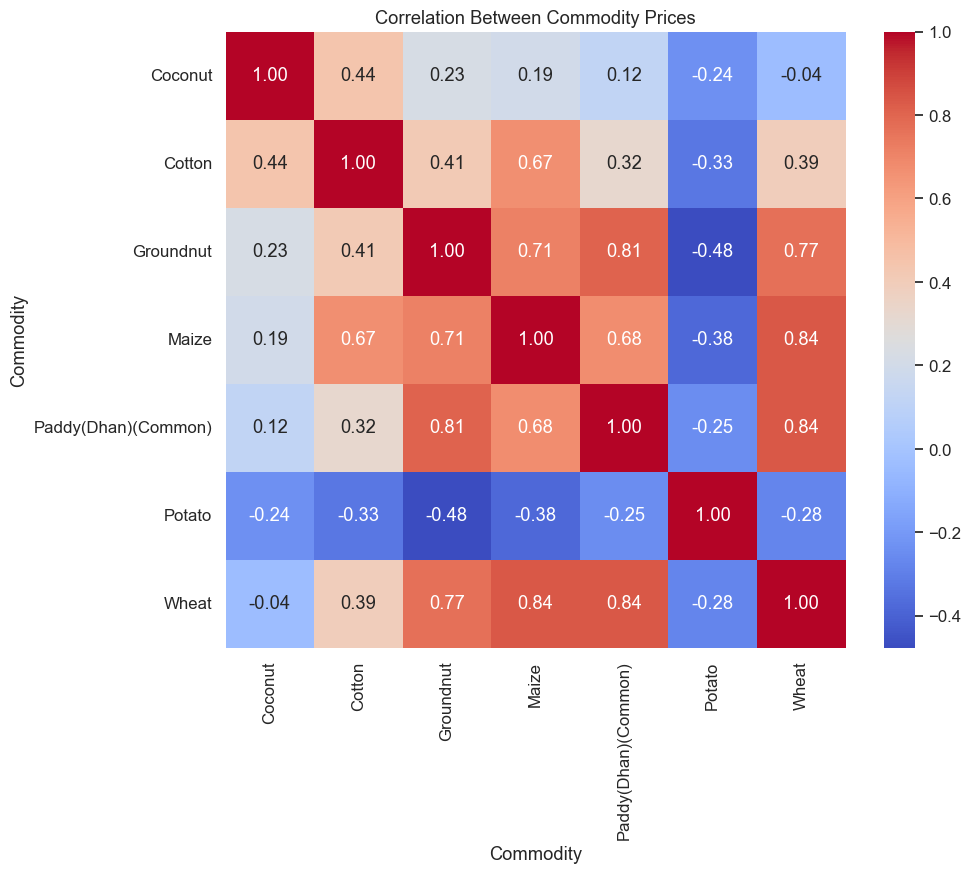

In [113]:
commodity_pivot = df.pivot_table(index="Price Date", columns="Commodity", values="Modal Price (Rs./Quintal)", aggfunc="mean")

plt.figure(figsize=(10,8))
sns.heatmap(commodity_pivot.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation Between Commodity Prices")
plt.show()

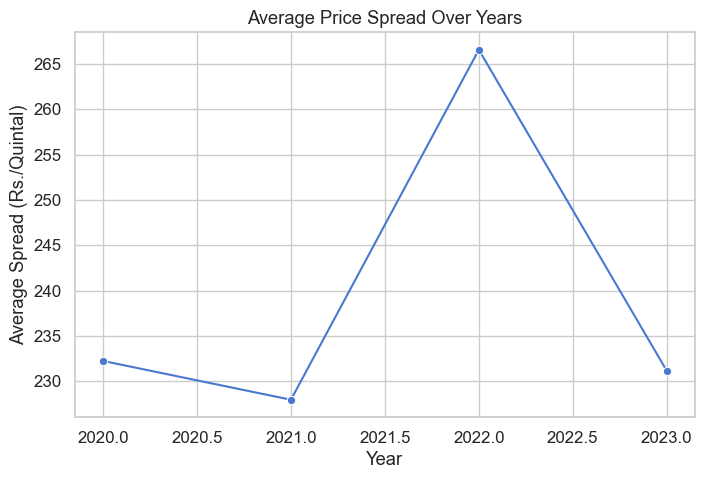

In [114]:
spread_year = df.groupby("Year")["Price Spread"].mean()

plt.figure(figsize=(8,5))
sns.lineplot(x=spread_year.index, y=spread_year.values, marker="o")
plt.title("Average Price Spread Over Years")
plt.xlabel("Year")
plt.ylabel("Average Spread (Rs./Quintal)")
plt.show()

In [115]:
df.head()

,Sl no.,District Name,Market Name,Commodity,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Price Date,Year,Month,Season,State,Price Volatility,Price Spread
1,1,Malda,Gajol,Groundnut,5500.0,5800.0,5700.0,2020-12-31,2020,12,Rabi,West Bengal,0.052632,300.0
2,2,Malda,Gajol,Groundnut,5500.0,6000.0,5800.0,2020-08-06,2020,8,Kharif,West Bengal,0.086207,500.0
3,3,Malda,Gajol,Groundnut,5500.0,6000.0,5800.0,2020-08-09,2020,8,Kharif,West Bengal,0.086207,500.0
4,4,Malda,Gajol,Groundnut,5800.0,6100.0,5900.0,2020-11-12,2020,11,Rabi,West Bengal,0.050847,300.0
5,5,Malda,Gajol,Groundnut,5800.0,6200.0,6000.0,2020-09-03,2020,9,Kharif,West Bengal,0.066667,400.0


In [130]:
df.columns

Index(['Sl no.', 'District Name', 'Market Name', 'Commodity',
       'Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)',
       'Modal Price (Rs./Quintal)', 'Price Date', 'Year', 'Month', 'Season',
       'State', 'Price Volatility', 'Price Spread'],
      dtype='object')

In [117]:
df.head()

,Sl no.,District Name,Market Name,Commodity,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Price Date,Year,Month,Season,State,Price Volatility,Price Spread
1,1,Malda,Gajol,Groundnut,5500.0,5800.0,5700.0,2020-12-31,2020,12,Rabi,West Bengal,0.052632,300.0
2,2,Malda,Gajol,Groundnut,5500.0,6000.0,5800.0,2020-08-06,2020,8,Kharif,West Bengal,0.086207,500.0
3,3,Malda,Gajol,Groundnut,5500.0,6000.0,5800.0,2020-08-09,2020,8,Kharif,West Bengal,0.086207,500.0
4,4,Malda,Gajol,Groundnut,5800.0,6100.0,5900.0,2020-11-12,2020,11,Rabi,West Bengal,0.050847,300.0
5,5,Malda,Gajol,Groundnut,5800.0,6200.0,6000.0,2020-09-03,2020,9,Kharif,West Bengal,0.066667,400.0


In [120]:
X = df[["Year","Month","Season","State","District Name","Commodity","Price Spread","Price Volatility"]]  
y = df["Modal Price (Rs./Quintal)"]
categorical_cols = ["Season", "State", "District Name", "Commodity"]
numeric_cols = ["Year","Month","Price Spread","Price Volatility"]

In [121]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_cols)
    ]
)

In [122]:
models = {
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=200, learning_rate=0.1, depth=6, verbose=0, random_state=42)
}


In [123]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [124]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ],
    remainder="passthrough"
)

In [125]:
X.isnull().sum()

Year                0
Month               0
Season              0
State               0
District Name       0
Commodity           0
Price Spread        0
Price Volatility    0
dtype: int64

In [126]:
# -----------------------------------------------
# FIX ALL MISSING / INVALID / INFINITE VALUES
# -----------------------------------------------

# Replace weird missing values
missing_vals = [" ", "", "NA", "N/A", "na", "null", "Null"]
df = df.replace({val: np.nan for val in missing_vals})

# Replace infinities
df = df.replace([np.inf, -np.inf], np.nan)

# Remove extremely large numeric values (greater than 1e10)
df = df.applymap(
    lambda x: np.nan if isinstance(x, (int, float)) and abs(x) > 1e10 else x
)

# Drop duplicates
df = df.drop_duplicates()

# Drop rows where target variable is missing
df = df.dropna(subset=["Modal Price (Rs./Quintal)"])


/var/folders/my/1tjr8gln2637t7t4cpykbl1w0000gn/T/ipykernel_69738/381704792.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


In [127]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


df = df.replace([" ", "", "NA", "N/A", "na", "null", "Null"], np.nan)
df = df.drop_duplicates()
df = df.dropna(subset=["Modal Price (Rs./Quintal)"])

df["Year"] = df["Year"].astype("int16")
df["Month"] = df["Month"].astype("int8")
df["Price Spread"] = pd.to_numeric(df["Price Spread"], errors="coerce").astype("float32")
df["Price Volatility"] = pd.to_numeric(df["Price Volatility"], errors="coerce").astype("float32")
df["Modal Price (Rs./Quintal)"] = df["Modal Price (Rs./Quintal)"].astype("float32")


features = ["Year","Month","Season","State","District Name","Commodity",
            "Price Spread","Price Volatility"]

X = df[features]
y = df["Modal Price (Rs./Quintal)"]

# Categorical Features Index
cat_features = [2,3,4,5]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)


model = CatBoostRegressor(
    iterations=400,
    learning_rate=0.1,
    depth=8,
    loss_function="RMSE",
    random_state=42,
    task_type="CPU",     # AUTO optimized
    verbose=100
)

model.fit(train_pool)


preds = model.predict(test_pool)
r2 = r2_score(y_test, preds)

print("\nOptimized CatBoost R² Score:", round(r2, 4))


0:	learn: 1158.2389713	total: 228ms	remaining: 1m 30s
100:	learn: 211.3910033	total: 10.9s	remaining: 32.3s
200:	learn: 164.0225439	total: 22.5s	remaining: 22.2s
300:	learn: 142.5038027	total: 33.7s	remaining: 11.1s
399:	learn: 129.9215340	total: 44.9s	remaining: 0us

Optimized CatBoost R² Score: 0.9801


In [63]:
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor

# Label encode categorical columns
X_lgb = X.copy()
for col in ["Season","State","District Name","Commodity"]:
    X_lgb[col] = LabelEncoder().fit_transform(X_lgb[col].astype(str))

X_train_lgb, X_test_lgb = train_test_split(X_lgb, test_size=0.2, random_state=42)

lgb_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8,
    random_state=42
)

lgb_model.fit(X_train_lgb, y_train)
lgb_pred = lgb_model.predict(X_test_lgb)
lgb_r2 = r2_score(y_test, lgb_pred)

print("LightGBM R²:", round(lgb_r2, 4))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 763504, number of used features: 8
[LightGBM] [Info] Start training from score 1943.806722
LightGBM R²: 0.9886
